<a href="https://colab.research.google.com/github/shiomasa1218/Colaboratory/blob/master/CNNshio_1ch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# drive mean root directory of  google drive
!ls ./gdrive/'My Drive'/'Kumamoto-Univ'/'Graduationwork'/'exefolder'/'test_folder_name'

In [0]:
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# check auth
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
cd gdrive/'My Drive'/'Kumamoto-Univ'/'Graduationwork'/'exefolder'/

/content/gdrive/My Drive/Kumamoto-Univ/Graduationwork/exefolder


8
1
train_soc321
test_folder_name
802
641
160
[array([103., 110., 124., ..., 174., 178., 179.])]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 1, 25, 256)
Instructions for updating:
Use tf.cast instead.
step 0, training accuracy 0.403333   test accuracy 0.2   training_loss 313.552 test_loss 313.975
step 10, training accuracy 0.508333   test accuracy 0.45625   training_loss 263.887 test_loss 263.998
step 20, training accuracy 0.536667   test accuracy 0.51875   training_loss 220.694 test_loss 220.88
step 30, training accuracy 0.598333   test accuracy 0.56875   training_loss 184.097 test_loss 183.944
step 40, training accuracy 0.636667   test accuracy 0.6375   training_loss 153.237 test_loss 153.314
step 50, training accuracy 0.68   test accuracy 0.6375   training_loss 127.471 test_loss 127.576
step 60, training accuracy 0.673333   test accuracy 

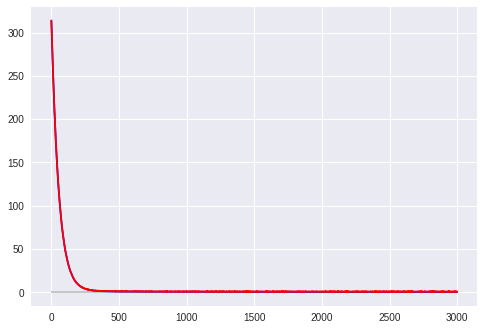

In [5]:
import tensorflow as tf
import os
import random
import numpy as np
import csv
import pandas as pd
import input_data
import time
import datetime
from sklearn.metrics import confusion_matrix,recall_score,precision_score,f1_score

import matplotlib.pyplot as plt

csv_epochs = []
csv_loss = []
csv_training_loss = []
csv_accuracy=[]
csv_training_accuracy = []


#フィルタ作成
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
     
def weight_variable_he(shape,nodes):
    initial = tf.truncated_normal(shape, stddev=np.sqrt(2.0/nodes))
    return tf.Variable(initial)
     
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W):
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')

def max_pool_1x2(x):
    return tf.nn.max_pool(x, ksize = [1,1,2,1], strides=[1,1,2,1],padding = 'SAME')

def batch_normalization(shape, input):
    eps = 1e-5
    gamma = weight_variable([shape])
    beta = weight_variable([shape])
    mean,variance = tf.nn.moments(input,[0])
    return gamma * (input - mean) / tf.sqrt(variance+eps) + beta

def Activation(x):
    datas = tf.nn.relu(x)
    #datas = tf.nn.tanh(x)
    return datas



#define
#Data_Classes = 8#学習クラス数
steps = 3000 #エポック数　学習の回数
BATCH_SIZE = 600 #ミニバッチの一回の学習で使う量
#TBATCH_SIZE = 10
Validation = 0.8  #  ここの値で分割 ex. Validation = 0.4 →　0.4:0.6　に分割
CaptureNumber = 200 #データ数　ミニバッチの大きさ、初期は２００個のデータ
drop = 1.0 #dropoutの係数、NNのノードがこれをかけた数になる

allCSize = 6400 #全結合サイズ,一番手前のテンソルのshape[?,1,44,64] → 1*44*64=2816
filterSize = 64 #畳みこみフィルタ（カーネル）数 今回は 1 x filiterSize の大きさ

# 訓練データのフォルダのパス
train_folder_name = "train_soc321"

# 検証データのフォルダのパス
test_folder_name = "test_folder_name"

#全訓練データとそのラベル
All_Datas = []
All_Label = []

#外部検証データとそのラベル
Ex_TestDatas=[]
Ex_Label = []

#並び順をシャッフルしたあとの訓練データ
All_SDatas =[]
All_SLabel = []

#分割後の訓練データ，学習するほう
train_data = []
train_label = []

#分割後の訓練データ，モデル評価するほう
test_data = []
test_label = []

#フォルダ中身のファイル名を取得
trainFolder = os.listdir(train_folder_name)
testFolder = os.listdir(test_folder_name)




#学習クラス数
Data_Classes = len(trainFolder)

# .DS_Storeがあるか検知
for i,d in enumerate(trainFolder):
    if d == ".DS_Store":
        Data_Classes = Data_Classes - 1
        print("DS!!!!!!!!!!!!!!!!!!!!!!!!!!!!")


print(Data_Classes)
print(len(testFolder))
print(train_folder_name)
print(test_folder_name)

#フォルダごとにみる
#訓練データの読み込み

dsflag = 0

for i,d in enumerate(trainFolder):
    #one_hot_vector生成用
    tmp = np.zeros(Data_Classes)
    if d != ".DS_Store":
        #フォルダ内のファイルのリストを取得
        files = os.listdir(train_folder_name + '/'+d)
        #print(files)

        #one_hot_vectorを作成
        tmp[i-dsflag] = 1
        #ファイル毎にみる
        for f in files:
                            
            #.DS_Storeをどかす
            if f != ".DS_Store":
                #どのファイルを見ているか確認用
                #print("load:"+f)

                datafile_path = train_folder_name + '/' + d+'/'+f

                #csvから読み込み
                data = np.loadtxt(datafile_path, delimiter=",")     #pbldata用
                
                
                #データ取り出し
                csv321 = data[:]
             
                
                flatdata = []
                flatdata.append(csv321)
          
                All_Datas.append(flatdata)
                #one_hot_vectorをラベルに追加
#                 print("load:"+f+" ohv: "+str(tmp))
                All_Label.append(tmp)
            else:
                print(".ds_storeを除去")
    else:
        print(".ds_storeを抹殺")
        print(i)
        dsflag = dsflag + 1


dsflag = 0

#検証データの読み込み
# for i, d in enumerate(testFolder):
#     #one_hot_vector生成用
#     tmp = np.zeros(Data_Classes)
#     if d != ".DS_Store":
#         # フォルダ内のファイルのリストを取得
#         files = os.listdir(test_folder_name + '/' + d)
#         #print(files)

#         #one_hot_vectorを作成
#         tmp[i-dsflag] = 1
#         #ファイル毎にみる
#         for f in files:
                            
#             #.DS_Storeをどかす
#             if f != ".DS_Store":
#                 #どのファイルを見ているか確認用
#                 #print("load:"+f)

#                 datafile_path = test_folder_name + '/' + d+'/'+f

#                 #csvから読み込み
#                 data = np.loadtxt(datafile_path, delimiter=",")     #pbldata用

#                  #3x200のデータに整形
#                 x_csv = data[1, :]
#                 y_csv = data[2, :]
#                 z_csv = data[3, :]
                
#                 start = random.randint(0, len(x_csv) - CaptureNumber)
#                 end = start + CaptureNumber

#                 x_data = x_csv[start:end]
#                 y_data = y_csv[start:end]
#                 z_data = z_csv[start:end]


#                 flatdata = []
#                 flatdata.append(x_data)
#                 flatdata.append(y_data)
#                 flatdata.append(z_data)

                
#                 Ex_TestDatas.append(flatdata)
#                 #one_hot_vectorをラベルに追加
#                 Ex_Label.append(tmp)
#             else:
#                 print(".ds_storeを除去")
#     else:
#         print("ex.ds_storeを抹殺")
#         dsflag = dsflag + 1
  
# print("Ex_Label")
# print(Ex_Label[0])

#訓練データ順列のシャッフル
np.random.seed(seed=32)
print(len(All_Datas))
Rindex = np.random.permutation(list(range(len(All_Datas))))
# print(Rindex)
for k in Rindex:
    All_SDatas.append(All_Datas[k])
    All_SLabel.append(All_Label[k])

    
#訓練データを学習に使うやつとモデルの評価に使うやつの２種に分ける
numberV = int(len(All_SDatas)*(Validation)) #訓練データ数
testV = len(All_SDatas) - numberV  #テストデータ数
train_data = All_SDatas[:numberV] #0.９まで
test_data = All_SDatas[numberV+1:]
train_label = All_SLabel[:numberV]
test_label = All_SLabel[numberV+1:]

print(len(train_data))
print(len(test_data))

print(train_data[0])

#----------
#numpy行列へ
#----------

train_data = np.array(train_data)
train_label = np.array(train_label)

test_data = np.array(test_data)
test_label = np.array(test_label)

sess = tf.InteractiveSession()
x = tf.placeholder('float', shape=[None,1,CaptureNumber]) #1x200のデータ
y_ = tf.placeholder('float', shape=[None, Data_Classes]) #正解ラベル
keep_prob = tf.placeholder('float')
                                     
# -----------------------------------------
# 畳み込みニューラルネットワーク
#
# (convconv -> bn -> pool -> drop) x3，
# (fc->drop) x2
# -----------------------------------------

#第1ブロック
W_conv1_1 = weight_variable([1,5,1,filterSize]) #1*5のフィルタ　入力３ｃｈ　出力６４枚
b_conv1_1 = bias_variable([filterSize]) #出力６４ch
x_image = tf.reshape(x,[-1,1,CaptureNumber,1]) #-１はreshapeに適切な数N　１*２００のデータ　３ｃｈ
h_conv1_1 = conv2d(x_image, W_conv1_1)#+b_conv1_1 
tan1_1 = Activation(h_conv1_1)
bn1_1 = batch_normalization(filterSize,tan1_1)

W_conv1_2 = weight_variable([1,5,filterSize,filterSize])
b_conv1_2 = bias_variable([filterSize])
h_conv1_2 = conv2d(bn1_1, W_conv1_2)#+b_conv1_2
tan1_2 = Activation(h_conv1_2)
bn1_2 = batch_normalization(filterSize,tan1_2)


h_pool1 = max_pool_1x2(bn1_2)
h_pool1_drop = tf.nn.dropout(h_pool1, keep_prob)

# #第1ブロック
# W_conv1_1 = weight_variable([1,5,1,filterSize]) #1*5のフィルタ　入力３ｃｈ　出力６４枚
# b_conv1_1 = bias_variable([filterSize]) #出力６４ch
# x_image = tf.reshape(x,[-1,1,CaptureNumber,1]) #-１はreshapeに適切な数N　１*２００のデータ　３ｃｈ
# h_conv1_1 = conv2d(x_image, W_conv1_1)#+b_conv1_1 
# tan1_1 = Activation(h_conv1_1)
# bn1_1 = batch_normalization(filterSize,tan1_1)
# # print(h_conv1_1.shape)

# W_conv1_2 = weight_variable([1,5,filterSize,filterSize])
# b_conv1_2 = bias_variable([filterSize])
# h_conv1_2 = conv2d(bn1_1, W_conv1_2)#+b_conv1_2
# tan1_2 = Activation(h_conv1_2)
# bn1_2 = batch_normalization(filterSize,tan1_2)

# h_pool1 = max_pool_1x2(bn1_2)
# h_pool1_drop = tf.nn.dropout(h_pool1, keep_prob)


# # #第2ブロック
W_conv2_1 = weight_variable([1,5,filterSize,filterSize*2])
b_conv2_1 = bias_variable([filterSize*2])
h_conv2_1 = conv2d(h_pool1_drop, W_conv2_1)+b_conv2_1
tan2_1 = Activation(h_conv2_1)
bn2_1 = batch_normalization(filterSize*2,tan2_1)

h_pool2 = max_pool_1x2(bn2_1)
h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob)



# W_conv2_1 = weight_variable([1,5,filterSize,filterSize*2])
# b_conv2_1 = bias_variable([filterSize*2])
# h_conv2_1 = conv2d(h_pool1_drop, W_conv2_1)+b_conv2_1
# tan2_1 = Activation(h_conv2_1)
# bn2_1 = batch_normalization(filterSize*2,tan2_1)

# W_conv2_2 = weight_variable([1,5,filterSize*2,filterSize*2])
# b_conv2_2 = bias_variable([filterSize*2])
# h_conv2_2 = conv2d(bn2_1, W_conv2_2)+b_conv2_2
# tan2_2 = Activation(h_conv2_2)
# bn2_2 = batch_normalization(filterSize*2,tan2_2)

# h_pool2 = max_pool_1x2(bn2_2)
# h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob)

# # print(h_pool2_drop .shape)

# #

# # #第3ブロック
W_conv3_1 = weight_variable([1,5,filterSize*2,filterSize*4])
b_conv3_1 = bias_variable([filterSize*4])
h_conv3_1 = conv2d(h_pool2_drop, W_conv3_1)+b_conv3_1
tan3_1 = Activation(h_conv3_1)
bn3_1 = batch_normalization(filterSize*4,tan3_1)

h_pool3 = max_pool_1x2(bn3_1)
h_pool3_drop = tf.nn.dropout(h_pool3, keep_prob)

# W_conv3_1 = weight_variable([1,5,filterSize*2,filterSize*4])
# b_conv3_1 = bias_variable([filterSize*4])
# h_conv3_1 = conv2d(h_pool2_drop, W_conv3_1)+b_conv3_1
# tan3_1 = Activation(h_conv3_1)
# bn3_1 = batch_normalization(filterSize*4,tan3_1)

# W_conv3_2 = weight_variable([1,5,filterSize*4,filterSize*4])
# b_conv3_2 = bias_variable([filterSize*4])
# h_conv3_2 = conv2d(bn3_1, W_conv3_2)+b_conv3_2
# tan3_2 = Activation(h_conv3_2)
# bn3_2 = batch_normalization(filterSize*4,tan3_2)


# h_pool3 = max_pool_1x2(bn3_2)
# h_pool3_drop = tf.nn.dropout(h_pool3, keep_prob)
print(h_pool3_drop .shape)
h_pool3_flat = tf.reshape(h_pool3_drop, [-1,allCSize])

# print(h_pool2_drop .shape)
# h_pool2_flat = tf.reshape(h_pool2_drop, [-1,allCSize])#

#全結合層
W_fc1 = weight_variable([allCSize, allCSize])
b_fc1 = bias_variable([allCSize])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)
# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)#
bn4 = batch_normalization(allCSize,h_fc1)

# #dropout
h_fc1_drop = tf.nn.dropout(bn4, 1.0)

# #全結合層
W_fc2 = weight_variable([allCSize, allCSize])
b_fc2 = bias_variable([allCSize])

h_fc2= tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
bn5 = batch_normalization(allCSize,h_fc1)

# #dropout
h_fc2_drop = tf.nn.dropout(bn5, 0.5)

#softmaxで出力#
W_fc4 = weight_variable([allCSize, Data_Classes])
b_fc4 = bias_variable([Data_Classes])
y_conv=tf.nn.softmax(tf.matmul(h_fc2_drop, W_fc4) + b_fc4)




#------------------
# 評価と損失関数
#------------------

#L2ノルムを足そうとした残骸
L2_sqr = tf.nn.l2_loss(W_conv1_1) + tf.nn.l2_loss(W_conv2_1)+tf.nn.l2_loss(W_conv1_2) + tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2)
lambda_2 = 0.001

#クロスエントロピー誤差関数，1e-7を足して，勾配消失を防止
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y_conv+1e-7),reduction_indices=[1]))
cross_entropy = cross_entropy + lambda_2*L2_sqr
# cross_entropy = -tf.reduce_sum(y_*tf.log(tf.clip_by_value(y_conv,1e-10,1.0)))

#重みの最適化
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
#　推定結果のy_convと正解ラベルy_が同じかどうか判定，correct_predictionがbool配列になってる
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_,1))
# 正答率
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# run
sess.run(tf.global_variables_initializer())



#
#学習器の保存処理
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state('./')
cwd = os.getcwd()


#処理時間計測
startTime = datetime.datetime.today()

#ログ
learn = open(train_folder_name+'/'+'log.csv','w')
result = open(train_folder_name+'/'+'result.txt','w')


learn.write("class,step\n" )
learn.write("%g,%g\n"%(Data_Classes,steps))
learn.write("step,train_a,test_a\n" )

#学習ループ
#配列に入れた加速度データから，ランダムにデータを選択，さらにそこから1x200に切り出して学習にかける
for i in range(steps):

    #加速度データの中からランダムにデータを選択
    batch_mask = np.random.choice(len(train_data),BATCH_SIZE)
    tbatch_mask = np.random.choice(len(test_data),BATCH_SIZE)

    #バッチ配列
    train_data_batch = []
    train_label_batch = train_label[batch_mask]
    test_data_batch = []
    
#     print(len(batch_mask))
    #1x200に切り出し_訓練データ
    for g in batch_mask:
#         rdata = train_data[g]
#         train_data_batch.append(rdata)
#         print(train_data[g])
        s_data = train_data[g]
        b_data = s_data[0]

#         print(len(b_data))
        rdata = []
        start = random.randint(0, len(b_data) - CaptureNumber)
        end = start + CaptureNumber

        x_data = b_data[start:end]
      
        rdata.append(x_data)
        train_data_batch.append(rdata)

    # 1x200に切り出し_テストデータ
    for g in range(len(test_data)):
#         rdata = test_data[g]
#         test_data_batch.append(rdata)
        b_data = test_data[g]
  

        b_x = b_data[0]
        rdata = []
        start = random.randint(0, len(b_x) - CaptureNumber)
        end = start + CaptureNumber

        x_data = b_x[start:end]
        rdata.append(x_data)
        test_data_batch.append(rdata)

    # 学習の実行　x＝データy＿＝ラベル keep_prob=dropoutでどれだけノード消すか
    w_out, _ = sess.run([y_conv, train_step],feed_dict={x: train_data_batch, y_: train_label_batch, keep_prob:drop})

    #精度の計算
    train_accuracy = accuracy.eval(feed_dict={
        x: train_data_batch, y_: train_label_batch, keep_prob:drop})
    csv_epochs.append(i)

    training_loss = cross_entropy.eval(feed_dict={
        x: train_data_batch, y_: train_label_batch, keep_prob:drop})
    csv_training_loss.append(training_loss)

    test_accuracy = accuracy.eval(feed_dict={
        x: test_data_batch, y_: test_label, keep_prob: drop})

    loss = cross_entropy.eval(feed_dict={
        x: test_data_batch, y_: test_label, keep_prob: drop})
    csv_loss.append(loss)

    csv_accuracy.append(test_accuracy)
    csv_training_accuracy.append(train_accuracy)
    
    # 10ステップごとに精度を記録
    if i % 10 == 0 :
        # 各epochで下記のようにその時のepochとlossなどを追加していく
        

        print("step %d, training accuracy %g   test accuracy %g   training_loss %g test_loss %g" % (i, train_accuracy, test_accuracy,training_loss, loss))
        learn.write("%d,%g,%g\n" % (i, train_accuracy, test_accuracy))

    #終了一回前にいろいろ作成
    if i == steps-1:

        # confusion matrix 作成
        y_p = tf.argmax(y_conv, 1)
        val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x: test_data_batch, y_: test_label, keep_prob: drop})
        y_true = np.argmax(test_label, 1)
        con = confusion_matrix(y_true, y_pred)
        print(con)

        #検証データ分類用
        #y_pred_1 = sess.run([y_p],feed_dict={x: Ex_TestDatas, keep_prob: drop})
        # y_pred2 = y_pred_1[0]
        # print(y_pred2)
        # print(len(y_pred2))



        print("ccn test 正答率 %g" % accuracy.eval(feed_dict={
            x: test_data_batch, y_: test_label, keep_prob: drop
        }))

#         print("ccn realtime test 正答率 %g" % accuracy.eval(feed_dict={
#             x: Ex_TestDatas, y_: Ex_Label, keep_prob: drop
#         }))

        #処理時間計測，終わり
        endTime = datetime.datetime.today()

        print("")
        print("開始時刻 %s" % (startTime))
        print("終了時刻 %s" % (endTime))

        learn.write("\n開始時刻 %s\n" % (startTime))
        learn.write("終了時刻 %s\n" % (endTime))
        learn.write("ccn test 正答率 %g" % accuracy.eval(feed_dict={
            x: test_data_batch, y_: test_label, keep_prob: drop
        }))

        #confusion matrixについて，精度を百分率表記したcon1と何が何回正解したかを表すconの両方つくる
        con_sum = np.sum(con, axis=1)
        con1 = []
        for a in range(len(con)):
            c = con[a] / con_sum[a]
            con1.append(c)

        print(con_sum)
        print(con)
        result.write("Confusion Matrix :\n")
        # np.savetxt('result.txt',con,fmt="%0.2f")
        np.savetxt(train_folder_name+'/'+'confusion-no.csv', con, fmt="%0.3f", delimiter=',')
        np.savetxt(train_folder_name+'/'+'confusion.csv', con1, fmt="%0.3f", delimiter=',')


        ##学習器の保存処理２
saver.save(sess,cwd+"\\0model.ckpt")





# 計算中あるいは計算終了時にpngグラフを作成
plt.plot(csv_epochs, csv_training_loss, "b", label="Training Loss")
plt.plot(csv_epochs, csv_loss, "r", label="Test Loss")
plt.vlines(csv_epochs[-1], 0, csv_loss[-1], color='0.75')
plt.hlines(csv_loss[-1], 0, csv_epochs[-1], color='0.75')
# plt.savefig("graphs/model_name.png")

# plt.plot(csv_epochs, csv_training_accuracy, "b", label="Training Accuracy")
# plt.plot(csv_epochs, csv_accuracy, "r", label="Test Accuracy")
# plt.vlines(csv_epochs[-1], 0, csv_accuracy[-1], color='0.75')
# plt.hlines(csv_accuracy[-1], 0, csv_epochs[-1], color='0.75')
# show()
# plt.savefig("graphs/model_name.png")


learn.close()

(0, 2)

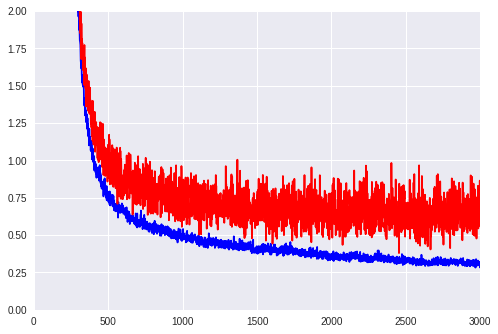

In [0]:
plt.plot(csv_epochs, csv_training_loss, "b", label="Training Loss")
plt.plot(csv_epochs, csv_loss, "r", label="Test Loss")
plt.xlim([0,steps])
plt.ylim([0,2])